In [1]:
import pandas as pd
import pylab as plt 
import seaborn as sns
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function Definition

In [2]:
# The p_value is returned to verify Stationarity
def p_value(df_value):
    result = adfuller(df_value.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [3]:
# Corelation and Differencing Plots (1 e 2).
def Differencing_Plot(df_value):  
    
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    axes[0, 0].plot(df_value)
    axes[0, 0].set_title('Original Series')
    plot_acf(df_value, ax=axes[0, 1])

    axes[1, 0].plot(df_value.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_value.diff().dropna(), ax=axes[1, 1])

    axes[2, 0].plot(df_value.diff().diff())
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df_value.diff().diff().dropna(), ax=axes[2, 1])

    fig.tight_layout()
    return plt.show()

In [4]:
def Model_Creation(parTrain, parMax_p, parMax_q, parSeasonal):
    model = auto_arima(   parTrain,
                          start_p = 0,
                          start_q = 0,
                          information_criterion = 'aic',
                          test = 'adf',
                          max_p = parMax_p,
                          max_q = parMax_q,
                          D = 1,
                          start_P = 0,
                          m = 12,
                          seasonal = parSeasonal,
                          trace = True,
                          error_action = "ignore",
                          suppress_warnings = True,
                          stepwise = True,
                          verbose = 1)
    return model.summary()

In [5]:
# Allows you to perform the study using SARIMAX
# Moreover a what if analysis between test data and prediction is introduced 
# A1: First element for the order of arima
# A2: Second element for the order of arima
# A3: Third element for the order of arima
# S1: First element for Sarima's order
# S2: Second element for Sarima's order
# S3: Third element for the order of Sarima

def Sarimax_Execution(parTrain,parTest,parColumn,parSteps,A1,A2,A3,S1,S2,S3,parSeason):
  
    # Model Built
    model = SARIMAX(parTrain, order=(A1,A2,A3), seasonal_order=(S1,S2,S3,parSeason))
    
    # Fitting model
    results = model.fit()
    
    # Plot parameters
    plt.rcParams['figure.figsize'] = 12, 8
    plot = results.plot_diagnostics()

    # SARIMA - Prevision with Confidence Intervall
    forecast = results.get_forecast(steps = parSteps)
    lower = forecast.conf_int()["lower " + parColumn]
    upper = forecast.conf_int()["upper " + parColumn]
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    plt.plot(parTrain, label='original',c='b')
    plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
    plt.plot(parTest, label='test',color='orange')
    plt.fill_between(forecast.conf_int().index,lower,upper,color='lightgray')
    plt.xlabel('Date')
    plt.ylabel('No of activated conracts')
    plt.legend()
    plt.show()

    return forecast

In [6]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    split_idx = round(len(Dismissals_Sondrio["SETTOREECONOMICO"])* train_size)

    # Split
    train = Dismissals_Sondrio.iloc[:split_idx]
    test = Dismissals_Sondrio.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

# Creation of the New DataSet for Time Serie

In [7]:
Dismissals = pd.read_csv('Lavori_Cessati_Cleaning.csv')

In [8]:
Dismissals_Sondrio = Dismissals.copy()

In [9]:
Dismissals_Sondrio.head(5)

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,TIPO,NAZIONE,ANNO,SETTOREECONOMICO
0,2021-03-11,M,55,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,MILANO,CESSATO,TUNISIA,2021,4
1,2021-05-03,M,55,Costruzione di edifici residenziali e non resi...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,CESSATO,ITALIA,2021,7
2,2021-05-12,M,34,Costruzione di edifici residenziali e non resi...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,CESSATO,EGITTO,2021,7
3,2019-04-08,M,27,Ristorazione con somministrazione,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,CESSATO,ITALIA,2019,2
4,2020-12-04,F,50,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,MILANO,CESSATO,ITALIA,2020,4


## Changing Columns Type

In [10]:
Dismissals_Sondrio['DATA'] = pd.to_datetime(Dismissals_Sondrio['DATA'])
Dismissals_Sondrio['SETTOREECONOMICO'] = pd.to_numeric(Dismissals_Sondrio['SETTOREECONOMICO'])

In [11]:
Dismissals_Sondrio.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
ANNO                                  int64
SETTOREECONOMICO                      int64
dtype: object

In [12]:
Dismissals_Sondrio.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,TIPO,NAZIONE,ANNO,SETTOREECONOMICO
0,2021-03-11,M,55,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,MILANO,CESSATO,TUNISIA,2021,4
1,2021-05-03,M,55,Costruzione di edifici residenziali e non resi...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,CESSATO,ITALIA,2021,7
2,2021-05-12,M,34,Costruzione di edifici residenziali e non resi...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,CESSATO,EGITTO,2021,7
3,2019-04-08,M,27,Ristorazione con somministrazione,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,CESSATO,ITALIA,2019,2
4,2020-12-04,F,50,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,MILANO,CESSATO,ITALIA,2020,4


In [13]:
Dismissals_Sondrio.PROVINCIAIMPRESA.unique()

array(['MILANO', 'SONDRIO'], dtype=object)

## Rebuilding of the DataSet

In [14]:
Dismissals_Sondrio = Dismissals_Sondrio[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA']]
Dismissals_Sondrio.head()

,DATA,SETTOREECONOMICODETTAGLIO,SETTOREECONOMICO,PROVINCIAIMPRESA
0,2021-03-11,Attività di famiglie e convivenze come datori ...,4,MILANO
1,2021-05-03,Costruzione di edifici residenziali e non resi...,7,MILANO
2,2021-05-12,Costruzione di edifici residenziali e non resi...,7,MILANO
3,2019-04-08,Ristorazione con somministrazione,2,MILANO
4,2020-12-04,Attività di famiglie e convivenze come datori ...,4,MILANO


In [15]:
Dismissals_Sondrio = Dismissals_Sondrio[Dismissals_Sondrio['PROVINCIAIMPRESA'] == 'SONDRIO']

In [16]:
Dismissals_Sondrio = Dismissals_Sondrio.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [17]:
Dismissals_Sondrio.head()

,SETTOREECONOMICO
DATA,
2008-01-31,4.0
2008-02-29,2.0
2008-03-31,4.0
2008-04-30,4.0
2008-05-31,4.0


In [18]:
Dismissals_Sondrio.shape

(166, 1)

# Time Series

<AxesSubplot:xlabel='DATA'>

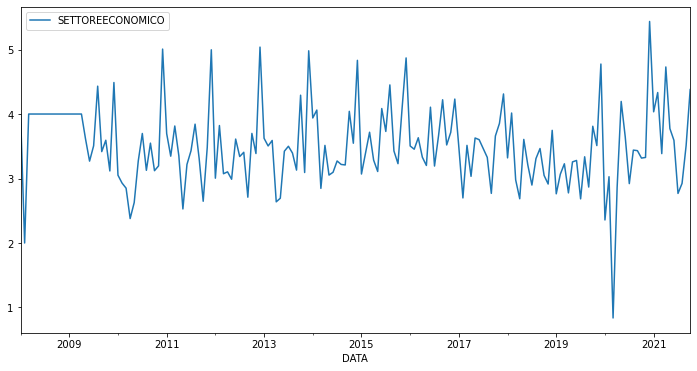

In [19]:
Dismissals_Sondrio.plot(figsize=(12,6))

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. 

### Multiplicative Seasonal Decompose

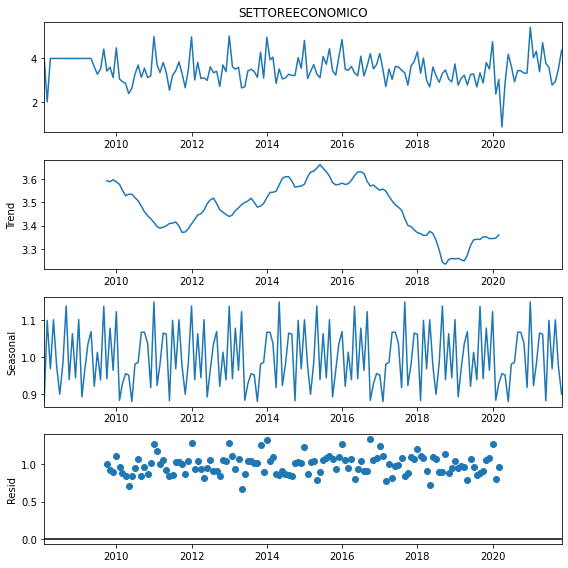

In [20]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul = seasonal_decompose(Dismissals_Sondrio['SETTOREECONOMICO'], model = 'multiplicative', period = 40)
decomposition_result = result_mul.plot()

### Additive Seasonal Decompose

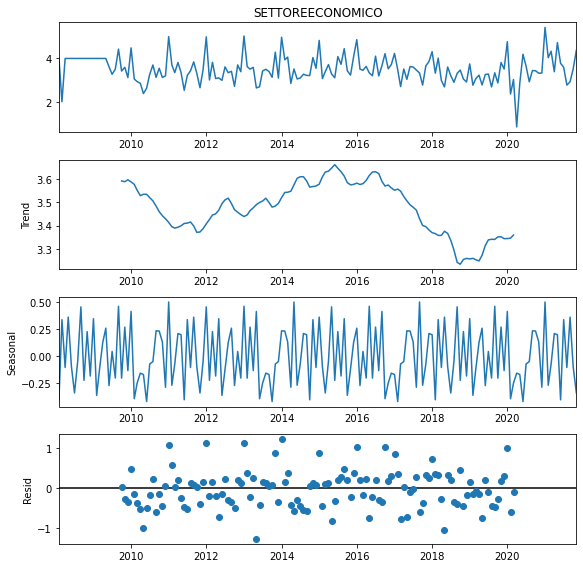

In [21]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_add = seasonal_decompose(Dismissals_Sondrio['SETTOREECONOMICO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

In [22]:
# ADF calculation
p_value(Dismissals_Sondrio["SETTOREECONOMICO"])

ADF Statistic: -2.681031
p-value: 0.077379


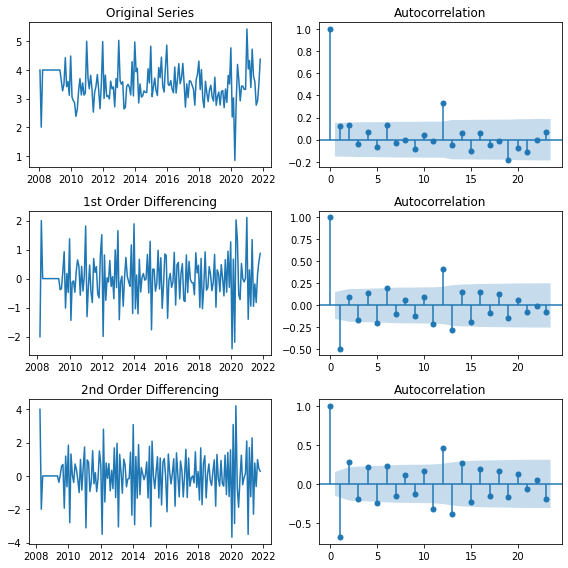

In [23]:
# Differencing plots representation
Differencing_Plot(Dismissals_Sondrio["SETTOREECONOMICO"])

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [24]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Dismissals_Sondrio["SETTOREECONOMICO"].diff())

ADF Statistic: -6.233931
p-value: 0.000000


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

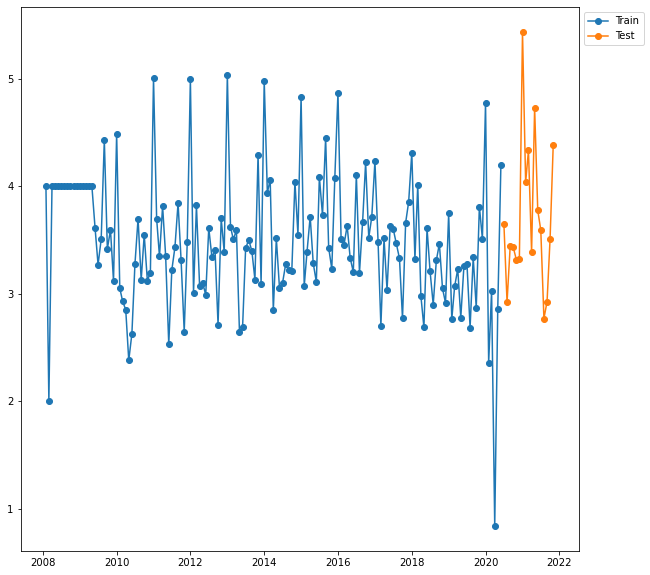

In [25]:
train, test = Dynamic_Splitting(Dismissals_Sondrio,"SETTOREECONOMICO",0.90)

## SARIMAX Model Creation

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [26]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=227.453, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=262.737, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=232.828, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=227.423, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=262.079, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=263.244, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=229.376, Time=0.29 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=229.393, Time=0.39 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=233.003, Time=0.13 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=230.756, Time=0.76 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=225.724, Time=0.36 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=264.767, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=227.279, Time=0.66 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=227.443, Time=0.87 sec
 ARIMA(1,0,1)(1,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  149
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -108.757
Date:                            Tue, 05 Jul 2022   AIC                            225.514
Time:                                    18:55:26   BIC                            237.194
Sample:                                         0   HQIC                           230.260
                                            - 149                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9526      0.067     14.249      0.000       0.822       1.084
ma.L1         -0.8566      0.099     -8.691      0.000      -1.050      -0.663
ma.S.L12      -0.7307      0.107     -6.838      0.000      -0.940      -0.521
sigma2         0.2689      0.024     11.338      0.000       0.222       0.315
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.41
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.24
Prob(H) (two-sided):                  0.88   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


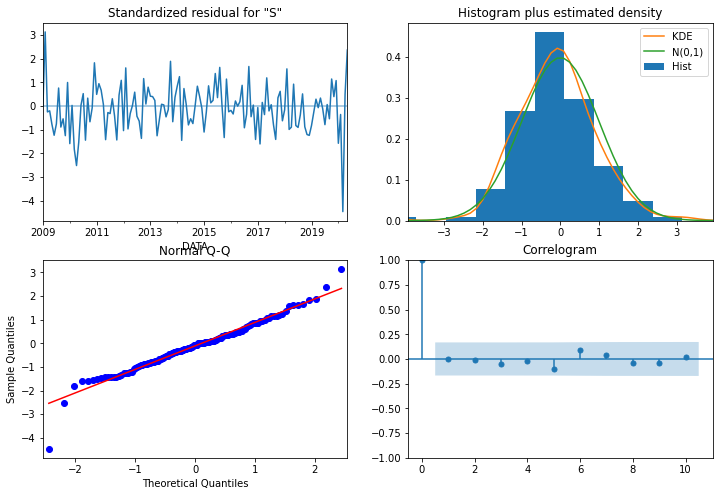

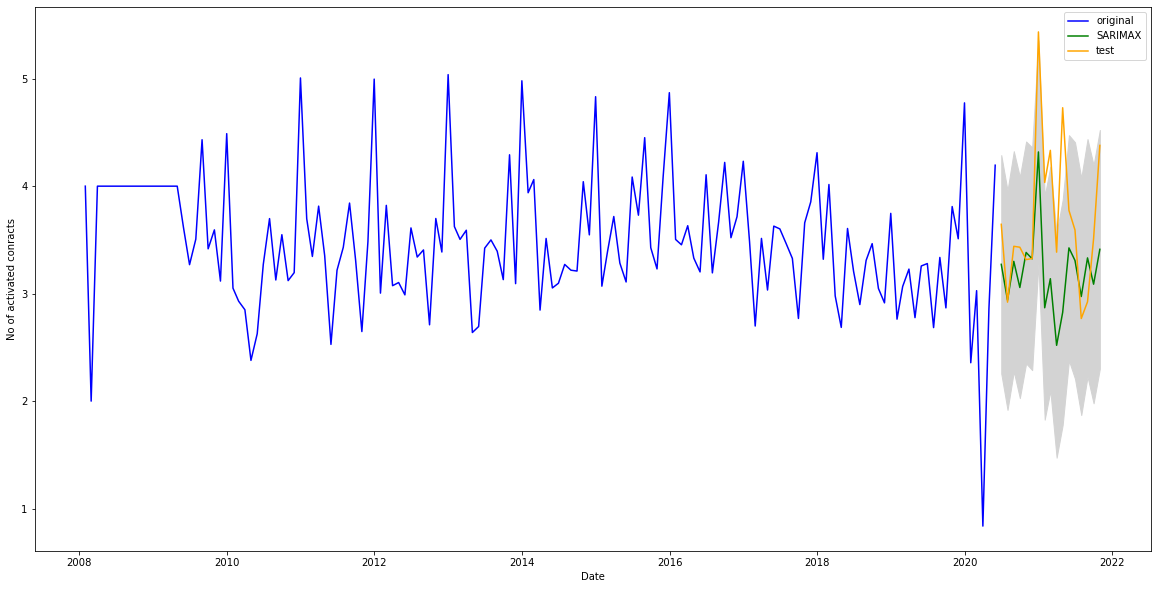

In [27]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"SETTOREECONOMICO",17,1,0,1,0,1,1,12)

In [28]:
# Metrics of Sarima Evalutation 
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.775980


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Machine Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [30]:
Dismissals_Sondrio.head(), Dismissals_Sondrio.tail()

(            SETTOREECONOMICO
 DATA                        
 2008-01-31               4.0
 2008-02-29               2.0
 2008-03-31               4.0
 2008-04-30               4.0
 2008-05-31               4.0,
             SETTOREECONOMICO
 DATA                        
 2021-06-30          3.591837
 2021-07-31          2.768595
 2021-08-31          2.924370
 2021-09-30          3.510638
 2021-10-31          4.379310)

In [31]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [32]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [33]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.75293373 0.27680601 0.75293373 0.75293373 0.75293373 0.75293373
 0.75293373 0.75293373 0.75293373 0.75293373 0.75293373 0.75293373]
Prediction: 
[[0.75293373]]


In [34]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [36]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(generator, epochs = 180)  #Epochs = Number of Iterations

Epoch 1/180
137/137 [==============================] - 2s 4ms/step - loss: 0.0476
Epoch 2/180
137/137 [==============================] - 0s 4ms/step - loss: 0.0261
Epoch 3/180
137/137 [==============================] - 1s 4ms/step - loss: 0.0228
Epoch 4/180
137/137 [==============================] - 1s 4ms/step - loss: 0.0222
Epoch 5/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 6/180
137/137 [==============================] - 1s 4ms/step - loss: 0.0231
Epoch 7/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 8/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 9/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 10/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 11/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 12/180
137/137 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 13/180


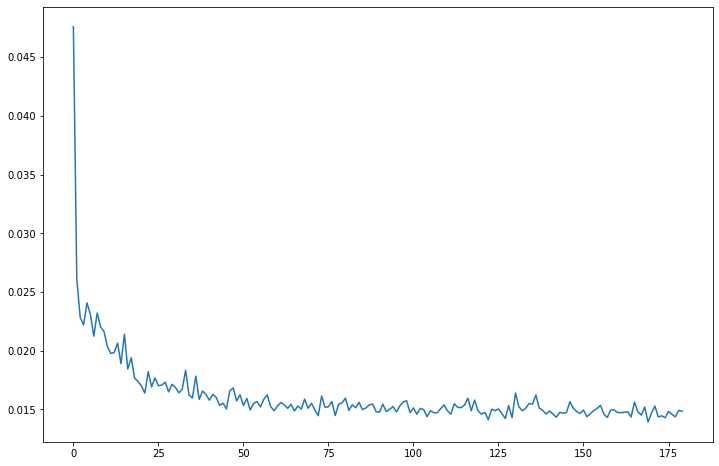

In [39]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [40]:
last_train_batch = scaled_train[-12:]

In [41]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 158ms/step


array([[0.58305544]], dtype=float32)

In [43]:
scaled_test[0]

array([0.66845946])

In [44]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [45]:
test_predictions

[array([0.58305544], dtype=float32),
 array([0.5720345], dtype=float32),
 array([0.58572364], dtype=float32),
 array([0.5817738], dtype=float32),
 array([0.6153255], dtype=float32),
 array([0.6195942], dtype=float32),
 array([0.90856826], dtype=float32),
 array([0.57851744], dtype=float32),
 array([0.57910895], dtype=float32),
 array([0.6097139], dtype=float32),
 array([0.59997165], dtype=float32),
 array([0.6765768], dtype=float32),
 array([0.58805263], dtype=float32),
 array([0.5824791], dtype=float32),
 array([0.5833688], dtype=float32),
 array([0.5825925], dtype=float32),
 array([0.5895268], dtype=float32)]

In [46]:
test.head()

,SETTOREECONOMICO
DATA,
2020-06-30,3.645161
2020-07-31,2.920792
2020-08-31,3.440476
2020-09-30,3.432000
2020-10-31,3.316832


In [47]:
true_predictions= scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_9428/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [49]:
test.head()

,SETTOREECONOMICO,Predictions
DATA,,
2020-06-30,3.645161,3.286417
2020-07-31,2.920792,3.240123
2020-08-31,3.440476,3.297625
2020-09-30,3.432000,3.281034
2020-10-31,3.316832,3.421969


In [50]:
#test = test[['SETTOREECONOMICO', 'PREVISIONI']]

<AxesSubplot:xlabel='DATA'>

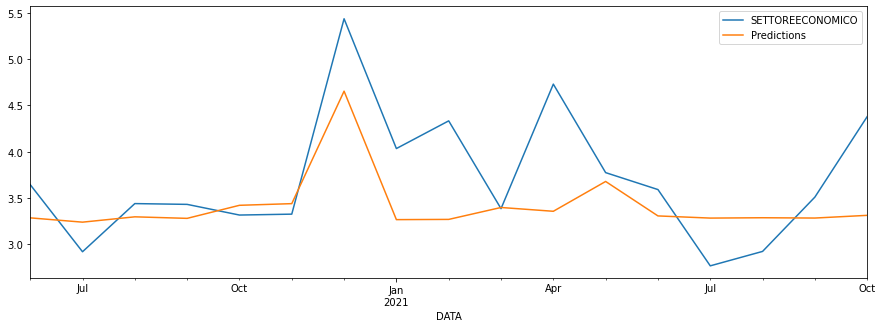

In [51]:
test.plot(figsize = (15,5))

In [52]:
rmse = sqrt(mean_squared_error(test['SETTOREECONOMICO'],test['Predictions']))
print(rmse)

0.603220975873205
